# Acoustic signal processing and feature analysis
### Notebook 6 (1): Deep learning feature preparation 
- Author： Chen Lequn


In [29]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage.transform import resize

In [2]:
## Audio signal processing libraries
import librosa
import librosa.display
import IPython.display as ipd
from scipy.fftpack import fft

In [8]:
## others
from glob import glob
import itertools
import os
from IPython.display import Image
from skimage.transform import resize

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight

# Keras
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

#To visualize the whole grid
pd.options.display.max_columns = 999

%matplotlib inline
%pylab inline

# matplotlib.rc_file_defaults()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Asus\anaconda3\envs\working_primary\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['resize', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
# ------------------- plotly visualizatoin----------------------------------
from PIL import Image
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from skimage import data

In [5]:
import scaleogram as scg 
from glob import glob
import glob
import re
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf

In [6]:
# Pytorch libraryes and torchaudio - for GPU accelerated feature extraction
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary

In [7]:
import plotly.express as px
import plotly.io as pio

In [11]:
import nussl

In [30]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"
Audio_PATH_original = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "original", 'train')
Audio_PATH_original_seg = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "original", "train_seg")
Audio_PATH_equalized = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "equalized")
Audio_PATH_bandpassed = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "bandpassed")
Audio_PATH_denoised = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "denoised", 'train')

Audio_PATH_original_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "original", "sliced_layers")
Audio_PATH_equalized_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "equalized", "sliced_layers")
Audio_PATH_bandpass_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "bandpassed", "sliced_layers")
Audio_PATH_denoised_layer = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "denoised", "sliced_layers")

Audio_PATH_original_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "segment", "original") 
Audio_PATH_equalized_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "segment", "equalized")  
Audio_PATH_bandpassed_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "segment", "bandpassed")
Audio_PATH_denoised_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "segment", "denoised")


label_file = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', 'label_v2.csv')

Experiment_PATH = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment')
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'AMDataset_v4_June_Experiment', "DL", "feature_extraction")
os.makedirs(Audio_PATH_original, exist_ok=True)
os.makedirs(Audio_PATH_original_seg, exist_ok=True)
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [12]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [13]:
sys.path.insert(0, '../utils')
import glob
import utils
import filter
import feature_extractions
from feature_extractions import amplitude_envelope
FRAME_SIZE = 512
HOP_LENGTH = 256

In [14]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [15]:
import natsort
import skimage

In [16]:
def extract_wavelet_transform(signal, sr, wavelet = 'shan1.5-1.0', period_length = 200, scale_resolution=5):
    # range of scales to perform the transform
    # scales = scg.periods2scales(np.arange(1, period_length+1, scale_resolution), wavelet, dt = 1/44100)   # give len of 120
    scales=np.arange(1, period_length)
    coef, freq = pywt.cwt(signal, scales, wavelet)
    return coef, freq

def plot_wavelet_transform_resize(signal, sr, wavelet = 'shan1.5-1.0', period_length = 200, scale_resolution=5, rescale_size=120):
    # range of scales to perform the transform
    # scales = scg.periods2scales(np.arange(1, period_length+1, scale_resolution), wavelet, dt = 1/44100)   # give len of 120
    # scales=np.arange(1, period_length)
    scales = scg.periods2scales(np.arange(1, period_length+1, scale_resolution))   #len(scales) : 120
    # coef, freq = pywt.cwt(signal, scales, wavelet)
    coef, freq = scg.fastcwt(signal, scales, wavelet)
    
    # resize the 2D cwt coeffs 
    rescale = skimage.transform.resize(abs(coef), (len(scales), rescale_size), mode = 'constant')
    
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 8));
    
    axs[0].imshow(abs(coef), cmap = 'jet', aspect = 'auto')
    axs[0].set_title("original")
    axs[1].imshow(rescale, cmap = 'jet', aspect = 'auto')
    axs[1].set_title("resize from 6k to 120 in time axis")


def extract_wavelet_transform_resize(signal, sr, wavelet = 'shan1.5-1.0', period_length = 200, scale_resolution=5, rescale_size=120):
    # range of scales to perform the transform
    # scales = scg.periods2scales(np.arange(1, period_length+1, scale_resolution), wavelet, dt = 1/44100)   # give len of 120
    # scales=np.arange(1, period_length)
    scales = scg.periods2scales(np.arange(1, period_length+1, scale_resolution))   #len(scales) : 120
    # coef, freq = pywt.cwt(signal, scales, wavelet)
    coef, freq = scg.fastcwt(signal, scales, wavelet)
    
    # resize the 2D cwt coeffs 
    rescale = skimage.transform.resize(abs(coef), (len(scales), rescale_size), mode = 'constant')
    
    return rescale


def extract_wavelet_transform_fast(signal, sr, wavelet = 'shan1.5-1.0', period_length = 200, scale_resolution=5):
    # range of scales to perform the transform
    # scales = scg.periods2scales(np.arange(1, period_length+1, scale_resolution), wavelet, dt = 1/44100)   # give len of 120
    scales=np.arange(1, period_length)
    coef, freq = scg.fastcwt(signal, scales, wavelet)
    return coef, freq

def plot_wavelet_transform(signal, sr, title, wavelet = 'shan1.5-1.0', period_length = 200, 
                           scale_resolution=5, set_colorbar = False, cmin=0, cmax=3):
    coef, freq = extract_wavelet_transform_fast(signal, sr, wavelet = wavelet, 
                                                period_length = period_length, scale_resolution=scale_resolution)
    
    plt.figure(figsize=(8, 4))
    # # fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 10));
    # fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), nrows=2)
    # # plot audio in time domain
    # ax1.plot(signal, linewidth = 3, color = 'blue')
    # # axs[0].set_title(df_ab['label'][select_list[row]])
    # wavelet = ax2.imshow(abs(coef), cmap = 'jet', aspect = 'auto') #aspect = 'auto'
    # if (set_colorbar==True):
    #     fig.colorbar(wavelet, ax=ax2, location='right', anchor=(0, 0.3), shrink=0.9, (cmin=0, cmax=3))
    # else:
    #     fig.colorbar(wavelet, ax=ax2, location='right', anchor=(0, 0.3), shrink=0.9)
    
    wavelet = plt.imshow(abs(coef), cmap = 'jet', aspect = 'auto') #aspect = 'auto'
    if (set_colorbar==True):
        plt.clim(cmin,cmax)
    else:
        # plt.clim(-4,4)
        pass
    
        
    
def plot_scaleogram(signal, sr, title, wavelet = 'shan1.5-1.0', period_length = 600, scale_resolution=50, coi = False, 
                    yscale = 'linear', set_colorbar = False, cmin=0, cmax=3):
    # plot heartbeat in time domain
    fig1, ax1 = plt.subplots(1,1, figsize = (9, 3));
    ax1.plot(signal, linewidth = 3, color = 'blue')
    # ax1.set_xlim(0, signal_length)
    ax1.set_title('Time-domain signal')

    # choose default wavelet function
    scg.set_default_wavelet(wavelet)

    # range of scales to perform the transform
    # scales = scg.periods2scales(np.arange(1, period_length+1, scale_resolution), wavelet)   # give len of 120
    scales=np.arange(1, period_length)
    # plot scalogram
    if (coi == False and set_colorbar==False):
        scg.cws(signal, scales=scales, figsize = (10, 5), coi = coi, ylabel = 'Period',
                xlabel = 'Time', title = 'AM acoustic signal Scaleogram ' + title ,
                cmap="jet", yscale=yscale
                )
    elif (set_colorbar==False and coi == True):
        scg.cws(signal, scales=scales, figsize = (10, 5), 
                coi='O',
                coikw={'alpha':1.0, 'facecolor':'pink', 'edgecolor':'green',
                'linewidth':5} ,
                ylabel = 'Period',
                xlabel = 'Time', title = 'AM acoustic signal Scaleogram ' + title ,
                cmap="jet", yscale=yscale,
                )
        
    elif (set_colorbar==True and coi == False):
        scg.cws(signal, scales=scales, figsize = (10, 5), 
                coi=False,
                ylabel = 'Period',
                xlabel = 'Time', title = 'AM acoustic signal Scaleogram ' + title ,
                cmap="jet", yscale=yscale,
                clim=(cmin, cmax)
                )
    else:
        scg.cws(signal, scales=scales, figsize = (10, 5), 
                coi='O',
                coikw={'alpha':1.0, 'facecolor':'pink', 'edgecolor':'green', 'linewidth':5},
                ylabel = 'Period',
                xlabel = 'Time', title = 'AM acoustic signal Scaleogram ' + title ,
                cmap="jet", yscale=yscale,
                clim=(cmin, cmax)
                )
    
  
    print("Wavelet function used to compute the transform:", scg.get_default_wavelet(), 
      "(", pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")
    
    
def plot_scaleogram_resize(signal, sr, title, wavelet = 'shan1.5-1.0', period_length = 600, scale_resolution=50, coi = False, 
                    yscale = 'linear', set_colorbar = False, cmin=0, cmax=3):
    # plot heartbeat in time domain
    fig1, ax1 = plt.subplots(1,1, figsize = (9, 3));
    ax1.plot(signal, linewidth = 3, color = 'blue')
    # ax1.set_xlim(0, signal_length)
    ax1.set_title('Time-domain signal')

    # choose default wavelet function
    scg.set_default_wavelet(wavelet)

    # range of scales to perform the transform
    # scales = scg.periods2scales(np.arange(1, period_length+1, scale_resolution), wavelet)   # give len of 120
    scales=np.arange(1, period_length)
    # plot scalogram
    if (coi == False and set_colorbar==False):
        scg.cws(signal, scales=scales, figsize = (10, 5), coi = coi, ylabel = 'Period',
                xlabel = 'Time', title = 'AM acoustic signal Scaleogram ' + title ,
                cmap="jet", yscale=yscale
                )
    elif (set_colorbar==False and coi == True):
        scg.cws(signal, scales=scales, figsize = (10, 5), 
                coi='O',
                coikw={'alpha':1.0, 'facecolor':'pink', 'edgecolor':'green',
                'linewidth':5} ,
                ylabel = 'Period',
                xlabel = 'Time', title = 'AM acoustic signal Scaleogram ' + title ,
                cmap="jet", yscale=yscale,
                )
        
    elif (set_colorbar==True and coi == False):
        scg.cws(signal, scales=scales, figsize = (10, 5), 
                coi=False,
                ylabel = 'Period',
                xlabel = 'Time', title = 'AM acoustic signal Scaleogram ' + title ,
                cmap="jet", yscale=yscale,
                clim=(cmin, cmax)
                )
    else:
        scg.cws(signal, scales=scales, figsize = (10, 5), 
                coi='O',
                coikw={'alpha':1.0, 'facecolor':'pink', 'edgecolor':'green', 'linewidth':5},
                ylabel = 'Period',
                xlabel = 'Time', title = 'AM acoustic signal Scaleogram ' + title ,
                cmap="jet", yscale=yscale,
                clim=(cmin, cmax)
                )
    
  
    print("Wavelet function used to compute the transform:", scg.get_default_wavelet(), 
      "(", pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

## Import data

## Load label

In [19]:
labels = pd.read_csv(label_file)
labels

,Sample,layer,label,Label
0,25,1,0,Defect-free
1,25,2,0,Defect-free
2,25,3,0,Defect-free
3,25,4,0,Defect-free
4,25,5,0,Defect-free
...,...,...,...,...
305,21,46,2,Keyhole pores
306,21,47,2,Keyhole pores
307,21,48,2,Keyhole pores
308,21,49,2,Keyhole pores


## Load audio data (segmented)

In [31]:
AM_wav_original = glob.glob1(Audio_PATH_original_segmented, '*.wav')
AM_wav_original = natsort.natsorted(AM_wav_original)
for i in range(len(AM_wav_original)):
    AM_wav_original[i]= Audio_PATH_original_segmented + "\\" + AM_wav_original[i]
print(f'Total wav file in Audio_PATH_original_segmented folder :{len(AM_wav_original)}')


AM_wav_equalized = glob.glob1(Audio_PATH_equalized_segmented, '*.wav')
AM_wav_equalized = natsort.natsorted(AM_wav_equalized)
for i in range(len(AM_wav_equalized)):
    AM_wav_equalized[i]= Audio_PATH_equalized_segmented + "\\" + AM_wav_equalized[i]
print(f'Total wav file in Audio_PATH_equalized_segmented folder :{len(AM_wav_equalized)}')


AM_wav_bandpass = glob.glob1(Audio_PATH_bandpassed_segmented, '*.wav')
AM_wav_bandpass = natsort.natsorted(AM_wav_bandpass)
for i in range(len(AM_wav_bandpass)):
    AM_wav_bandpass[i]= Audio_PATH_bandpassed_segmented + "\\" + AM_wav_bandpass[i]
print(f'Total wav file in Audio_PATH_bandpassed_segmented folder :{len(AM_wav_bandpass)}')


AM_wav_denoised = glob.glob1(Audio_PATH_denoised_segmented, '*.wav')
AM_wav_denoised = natsort.natsorted(AM_wav_denoised)
for i in range(len(AM_wav_denoised)):
    AM_wav_denoised[i]= Audio_PATH_denoised_segmented + "\\" + AM_wav_denoised[i]
    
print(f'Total wav file in Audio_PATH_denoised_segmented folder :{len(AM_wav_denoised)}')


dataset_original = []
dataset_equalized = []
dataset_bandpassed= []
dataset_denoised = []


def generate_structured_datset(files, dataset_name):
    for file in files:
        # experiment_22_layer_1_slice_0_raw.wav
        experiment_number = int(os.path.basename(file).split("_")[1])  
        layer_number = int(os.path.basename(file).split("_")[3])  
        slice_number = os.path.basename(file).split("_")[5]
        signal_category = os.path.basename(file).split("_")[6].split(".")[0]
        filename = os.path.basename(file)
        filepath = file
        dur = librosa.get_duration(filename = file)
        signal = librosa.load(file, sr=None)[0]
        # compile label wav
        dataset_name.append({'filename': filename,
                                 'wav_duration' : dur,
                                 'file_path' : filepath,
                                 'Sample' : experiment_number,
                                 'layer' : layer_number,
                                 'signal_category' : signal_category,
                                 'signal': signal,
                                })
    print ("dataset created")
        
generate_structured_datset(AM_wav_original, dataset_original)
generate_structured_datset(AM_wav_equalized, dataset_equalized)
generate_structured_datset(AM_wav_bandpass, dataset_bandpassed)
generate_structured_datset(AM_wav_denoised, dataset_denoised)

Total wav file in Audio_PATH_original_segmented folder :1251
Total wav file in Audio_PATH_equalized_segmented folder :1251
Total wav file in Audio_PATH_bandpassed_segmented folder :1251
Total wav file in Audio_PATH_denoised_segmented folder :1251
dataset created
dataset created
dataset created
dataset created


### convert dataset into dataframe

In [32]:
### convert AM_dataset into dataframe
df_dataset_original = pd.DataFrame(dataset_original)
df_dataset_equalized = pd.DataFrame(dataset_equalized)
df_dataset_bandpassed = pd.DataFrame(dataset_bandpassed)
df_dataset_denoised = pd.DataFrame(dataset_denoised)

print(f'df_dataset_original : {df_dataset_original.shape}')
print(f'df_dataset_equalized : {df_dataset_equalized.shape}')
print(f'df_dataset_bandpassed : {df_dataset_bandpassed.shape}')
print(f'df_dataset_denoised : {df_dataset_denoised.shape}')

df_dataset_denoised.head()

df_dataset_original : (1251, 7)
df_dataset_equalized : (1251, 7)
df_dataset_bandpassed : (1251, 7)
df_dataset_denoised : (1251, 7)


,filename,wav_duration,file_path,Sample,layer,signal_category,signal
0,experiment_21_layer_1_slice_0_denoised.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,denoised,"[0.033721924, 0.0012817383, -0.033996582, -0.0..."
1,experiment_21_layer_1_slice_1_denoised.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,denoised,"[0.021148682, -0.0010681152, -0.014373779, -0...."
2,experiment_21_layer_1_slice_2_denoised.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,denoised,"[-0.02154541, 0.015289307, 0.044952393, 0.0350..."
3,experiment_21_layer_1_slice_3_denoised.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,denoised,"[0.07165527, 0.112091064, 0.024383545, -0.0785..."
4,experiment_21_layer_2_slice_0_denoised.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,2,denoised,"[-0.037872314, -0.024932861, 0.017944336, 0.03..."


In [33]:
print (df_dataset_equalized["file_path"][1])

../AM_audio_dataset\AMDataset_v4_June_Experiment\wave_file\segment\equalized\experiment_21_layer_1_slice_1_equalized.wav


In [34]:
df_dataset_original.head()

,filename,wav_duration,file_path,Sample,layer,signal_category,signal
0,experiment_21_layer_1_slice_0_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,raw,"[0.03604126, 0.040527344, 0.012145996, -0.0064..."
1,experiment_21_layer_1_slice_1_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,raw,"[-0.047729492, -0.04736328, -0.034454346, -0.0..."
2,experiment_21_layer_1_slice_2_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,raw,"[-0.009490967, -0.0284729, -0.045135498, -0.03..."
3,experiment_21_layer_1_slice_3_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,raw,"[-0.035583496, 0.011688232, -0.007965088, -0.0..."
4,experiment_21_layer_2_slice_0_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,2,raw,"[0.002105713, -0.013366699, 0.0029296875, 0.03..."


In [35]:
df_dataset_original = pd.merge(df_dataset_original, labels)
df_dataset_equalized = pd.merge(df_dataset_equalized, labels)
df_dataset_bandpassed = pd.merge(df_dataset_bandpassed, labels)
df_dataset_denoised = pd.merge(df_dataset_denoised, labels)

In [36]:
df_dataset_original.head()

,filename,wav_duration,file_path,Sample,layer,signal_category,signal,label,Label
0,experiment_21_layer_1_slice_0_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,raw,"[0.03604126, 0.040527344, 0.012145996, -0.0064...",0,Defect-free
1,experiment_21_layer_1_slice_1_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,raw,"[-0.047729492, -0.04736328, -0.034454346, -0.0...",0,Defect-free
2,experiment_21_layer_1_slice_2_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,raw,"[-0.009490967, -0.0284729, -0.045135498, -0.03...",0,Defect-free
3,experiment_21_layer_1_slice_3_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,1,raw,"[-0.035583496, 0.011688232, -0.007965088, -0.0...",0,Defect-free
4,experiment_21_layer_2_slice_0_raw.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,2,raw,"[0.002105713, -0.013366699, 0.0029296875, 0.03...",0,Defect-free


## Exploratory data analysis

In [37]:
df_dataset_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 0 to 1250
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         1251 non-null   object 
 1   wav_duration     1251 non-null   float64
 2   file_path        1251 non-null   object 
 3   Sample           1251 non-null   int64  
 4   layer            1251 non-null   int64  
 5   signal_category  1251 non-null   object 
 6   signal           1251 non-null   object 
 7   label            1251 non-null   int64  
 8   Label            1251 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 97.7+ KB


In [38]:
categories = df_dataset_denoised['Label'].unique() # five unique labels
categories

array(['Defect-free', 'Cracks', 'Keyhole pores'], dtype=object)

### Data distribution

Saving figure dataset_2


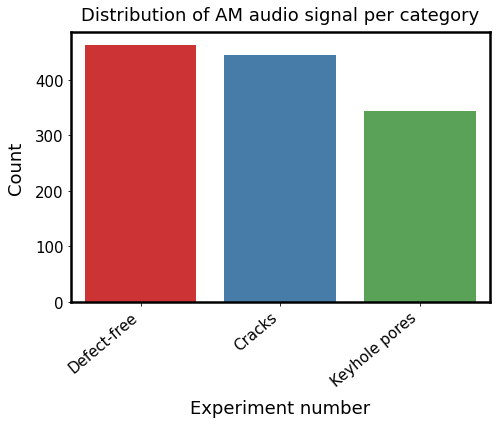

In [39]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='Label', data = df_dataset_denoised, palette="Set1"); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of AM audio signal per category', fontsize = 18, pad=12);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset_2")

### Ramdon checking

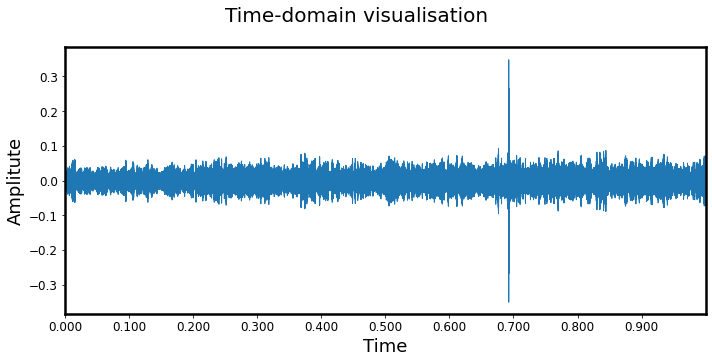

In [40]:
# signal, sr = librosa.load(AM_wav_denoised[20], sr=None)
signal = df_dataset_denoised.signal[400]
utils.simple_visualization(signal)

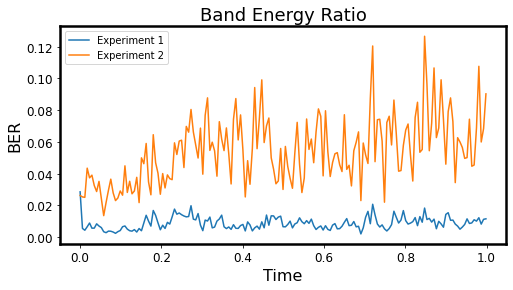

In [42]:
feature_extractions.band_energy_ratio_plot([df_dataset_denoised.signal[400],df_dataset_equalized.signal[400]], frame_size=FRAME_SIZE, 
                                           hop_length=HOP_LENGTH,sampling_rate = 44100, N_smooth = 1, split_frequency = 2000)

### Train Test Split

Train test split the dataset into 80%-20% train-test dataset

In [43]:
df_dataset_denoised.Label

0         Defect-free
1         Defect-free
2         Defect-free
3         Defect-free
4         Defect-free
            ...      
1246    Keyhole pores
1247    Keyhole pores
1248    Keyhole pores
1249    Keyhole pores
1250    Keyhole pores
Name: Label, Length: 1251, dtype: object

In [44]:
# Split the data into training and testing sets:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)
train_original, test_original = train_test_split(df_dataset_original, test_size = 0.2, random_state = 123, 
                                stratify = df_dataset_original.Label, shuffle = True)

train_equalized, test_equalized = train_test_split(df_dataset_equalized, test_size = 0.2, random_state = 123, 
                                stratify = df_dataset_equalized.Label, shuffle = True)

train_bandpassed, test_bandpassed = train_test_split(df_dataset_bandpassed, test_size = 0.2, random_state = 123, 
                                stratify = df_dataset_bandpassed.Label, shuffle = True)

train_denoised, test_denoised = train_test_split(df_dataset_denoised, test_size = 0.2, random_state = 123, 
                                stratify = df_dataset_denoised.Label, shuffle = True)

In [48]:
train_equalized.file_path[2]

'../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\segment\\equalized\\experiment_21_layer_1_slice_2_equalized.wav'

In [49]:
train_equalized.head()

,filename,wav_duration,file_path,Sample,layer,signal_category,signal,label,Label
312,experiment_22_layer_29_slice_0_equalized.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,22,29,equalized,"[-0.022949219, -0.018157959, 0.012542725, 0.02...",1,Cracks
930,experiment_25_layer_11_slice_0_equalized.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,25,11,equalized,"[0.03286743, -0.004486084, -0.039245605, -0.03...",0,Defect-free
685,experiment_24_layer_18_slice_0_equalized.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,24,18,equalized,"[-0.023223877, 0.08831787, 0.093811035, 0.0166...",0,Defect-free
104,experiment_21_layer_27_slice_0_equalized.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,27,equalized,"[0.015563965, 0.02468872, 0.050445557, 0.02102...",1,Cracks
192,experiment_21_layer_49_slice_0_equalized.wav,1.0,../AM_audio_dataset\AMDataset_v4_June_Experime...,21,49,equalized,"[0.099243164, 0.096832275, -0.03704834, -0.120...",2,Keyhole pores


## Feature Extractions from audio wav 

### MFCC feature extraction

### Define function to normalize the MFCC

Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in `[0, 1]`.

In [50]:
def feature_normalize(data):               # data is in numpy array (40,x)
    data_normalize = []
    data_max = np.max(data, axis =0)       # max value per row, 
    data_min = np.min(data, axis =0)       # min value per row
    for i in range(len(data)):
        data_nor = [(x - data_min[i])/(data_max[i] - data_min[i]) for x in data[i]] #normalize each value in 'x'
        data_normalize.append(data_nor)
    return np.asarray(data_normalize)      #convert back to numpy array

### Function for zero padding
def zero_pad(data, file_length, pad, truncate):
    data = pad_sequences(data, maxlen = file_length, dtype = 'float',
                       padding = pad, truncating= truncate, value = 0.)
    return data

### Function to extract MFCC:

- MFCC feature extraction
- Normalization of MFCC 

In [51]:
### Function to pre-process and then extract the MFCC feature
def extract_feature(data, sr):
     
    # extract mfcc feature
    mfccs = librosa.feature.mfcc(y = data, sr = sr, n_mfcc = 20)
    
    # mfccs normalization [0,1]
    mfccs_sc = feature_normalize(mfccs)
    
    return mfccs_sc

### Extract X-features

- These includes **train, test** datasets and also the unlabel dataset from set_a & set_b
- The data is with imbalance class treatment (synthesize new sample + oversampling)

In [52]:
%%time
### load labeled dataset (i.e.: both train & test)
### resuls of dataset are compilation of data with the same length of samples 
sfreq = 44100

dataset_train_original = []
dataset_test_original = []

dataset_train_equalized = []
dataset_test_equalized = []

dataset_train_bandpassed = []
dataset_test_bandpassed = []

dataset_train_denoised = []
dataset_test_denoised = []

#----------------------------------------------------------------------
dataset_train_original = train_original.signal.to_list()
dataset_test_original = test_original.signal.to_list()

dataset_train_equalized = train_equalized.signal.to_list()
dataset_test_equalized = test_equalized.signal.to_list()

dataset_train_bandpassed = train_bandpassed.signal.to_list()
dataset_test_bandpassed = test_bandpassed.signal.to_list()

dataset_train_denoised = train_denoised.signal.to_list()
dataset_test_denoised = test_denoised.signal.to_list()


CPU times: total: 0 ns
Wall time: 0 ns


In [55]:
# train_original.signal

In [53]:
%time
### Extract mfcc feature
X_train_original = []
X_test_original = []

for i in range(len(dataset_train_original)):
    X_train_original.append(extract_feature(dataset_train_original[i], sfreq))

for i in range(len(dataset_test_original)):
    X_test_original.append(extract_feature(dataset_test_original[i], sfreq))
    
### change X to array
X_train_original = np.asarray(X_train_original)
X_test_original = np.asarray(X_test_original)

print(f'X_train_original: {X_train_original.shape}')
print(f'X_test_original: {X_test_original.shape}')

CPU times: total: 0 ns
Wall time: 0 ns
X_train_original: (1000, 20, 87)
X_test_original: (251, 20, 87)


### get the target: y_train & y_test 

This can be share with other set of feature (e.g., CWT)

In [54]:
### Extract label as y-target and one-hot encode to integer
y_train_original = train_original.Label
y_test_original = test_original.Label

le = LabelEncoder()
y_train_original = le.fit_transform(y_train_original)
y_test_original = le.transform(y_test_original)

# to get back the label, use le.inverse_transform(ys)
print(f"y_train_original: {y_train_original.shape}")
print(f"y_test_original: {y_test_original.shape}")

y_train_original: (1000,)
y_test_original: (251,)


### Compute class weight

This is the 3rd step of treating the imbalanced class, which is calculating the class weight and use it for weighting the loss function (during training only). This steps need to repeat for 2nd set of feature (CWT)

`'balanced'` => n_samples / (n_classes * np.bincount(y))

In [55]:
class_weights_original = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train_original),
                                                 y = y_train_original)
print(f"class weights: {class_weights_original}")
print(f"class        : {np.unique(le.inverse_transform(y_train_original))}")

class weights: [0.93632959 0.90334237 1.21212121]
class        : ['Cracks' 'Defect-free' 'Keyhole pores']


### Re-shape X and change y to dummies (one-hot encoding)

In [56]:
X_train_original = X_train_original.reshape(X_train_original.shape[0], X_train_original.shape[1], X_train_original.shape[2], 1)
X_test_original = X_test_original.reshape(X_test_original.shape[0], X_test_original.shape[1], X_test_original.shape[2], 1)

### change int categorical to dummies
y_train_original = to_categorical(y_train_original)
y_test_original = to_categorical(y_test_original)

print(f'shape X_train_original : {X_train_original.shape}')
print(f'shape X_test_original : {X_test_original.shape}')
print(f'shape y_train_original : {y_train_original.shape}')
print(f'shape y_test_original : {y_test_original.shape}')

shape X_train_original : (1000, 20, 87, 1)
shape X_test_original : (251, 20, 87, 1)
shape y_train_original : (1000, 3)
shape y_test_original : (251, 3)


In [62]:
# y_test_original

### Store the pre-processed data for modelling in the next notebook

In [57]:
### store the preprocessed data for use in the next notebook

%store X_train_original 
%store X_test_original 
%store y_train_original
%store y_test_original 
%store le
%store class_weights_original

Stored 'X_train_original' (ndarray)
Stored 'X_test_original' (ndarray)
Stored 'y_train_original' (ndarray)
Stored 'y_test_original' (ndarray)
Stored 'le' (LabelEncoder)
Stored 'class_weights_original' (ndarray)


# Wrap the entire process into a function

In [58]:
def extract_mfcc_feature_dataset_prepare(dataset_train, dataset_test, train, test, sfreq=44100):
    %time
    
    
    X_train = []
    X_test = []
    
    for i in range(len(dataset_train)):
        X_train.append(extract_feature(dataset_train[i], sfreq))

    for i in range(len(dataset_test)):
        X_test.append(extract_feature(dataset_test[i], sfreq))

    ### change X to array
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)

    print(f'X_train: {X_train.shape}')
    print(f'X_test: {X_test.shape}')
    
    ### Extract label as y-target and one-hot encode to integer
    y_train = train.Label
    y_test = test.Label

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # to get back the label, use le.inverse_transform(ys)
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    class_weights= class_weight.compute_class_weight('balanced',
                                                     classes = np.unique(y_train),
                                                     y = y_train)
    print(f"class weights: {class_weights}")
    print(f"class        : {np.unique(le.inverse_transform(y_train))}")
    
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

    ### change int categorical to dummies
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    print(f'shape X_train : {X_train.shape}')
    print(f'shape X_test : {X_test.shape}')
    print(f'shape y_train : {y_train.shape}')
    print(f'shape y_test : {y_test.shape}')
    
    return X_train, X_test, y_train, y_test, le, class_weights

In [59]:
X_train_equalized, X_test_equalized, y_train_equalized, y_test_equalized, le_equalized, class_weights_equalized = extract_mfcc_feature_dataset_prepare(dataset_train_equalized,
dataset_test_equalized, train_equalized, test_equalized)

X_train_bandpassed, X_test_bandpassed, y_train_bandpassed, y_test_bandpassed, le_bandpassed, class_weights_bandpassed = extract_mfcc_feature_dataset_prepare(dataset_train_bandpassed,
dataset_test_bandpassed, train_bandpassed, test_bandpassed)

X_train_denoised, X_test_denoised, y_train_denoised, y_test_denoised, le_denoised, class_weights_denoised = extract_mfcc_feature_dataset_prepare(dataset_train_denoised,
dataset_test_denoised, train_denoised, test_denoised)

CPU times: total: 0 ns
Wall time: 0 ns
X_train: (1000, 20, 87)
X_test: (251, 20, 87)
y_train: (1000,)
y_test: (251,)
class weights: [0.93632959 0.90334237 1.21212121]
class        : ['Cracks' 'Defect-free' 'Keyhole pores']
shape X_train : (1000, 20, 87, 1)
shape X_test : (251, 20, 87, 1)
shape y_train : (1000, 3)
shape y_test : (251, 3)
CPU times: total: 0 ns
Wall time: 0 ns
X_train: (1000, 20, 87)
X_test: (251, 20, 87)
y_train: (1000,)
y_test: (251,)
class weights: [0.93632959 0.90334237 1.21212121]
class        : ['Cracks' 'Defect-free' 'Keyhole pores']
shape X_train : (1000, 20, 87, 1)
shape X_test : (251, 20, 87, 1)
shape y_train : (1000, 3)
shape y_test : (251, 3)
CPU times: total: 0 ns
Wall time: 0 ns
X_train: (1000, 20, 87)
X_test: (251, 20, 87)
y_train: (1000,)
y_test: (251,)
class weights: [0.93632959 0.90334237 1.21212121]
class        : ['Cracks' 'Defect-free' 'Keyhole pores']
shape X_train : (1000, 20, 87, 1)
shape X_test : (251, 20, 87, 1)
shape y_train : (1000, 3)
shape y

In [60]:
### store the preprocessed data for use in the next notebook

%store X_train_equalized 
%store X_test_equalized 
%store y_train_equalized
%store y_test_equalized 
%store le_equalized
%store class_weights_equalized

Stored 'X_train_equalized' (ndarray)
Stored 'X_test_equalized' (ndarray)
Stored 'y_train_equalized' (ndarray)
Stored 'y_test_equalized' (ndarray)
Stored 'le_equalized' (LabelEncoder)
Stored 'class_weights_equalized' (ndarray)


In [61]:
### store the preprocessed data for use in the next notebook

%store X_train_bandpassed 
%store X_test_bandpassed 
%store y_train_bandpassed
%store y_test_bandpassed 
%store le_bandpassed
%store class_weights_bandpassed

Stored 'X_train_bandpassed' (ndarray)
Stored 'X_test_bandpassed' (ndarray)
Stored 'y_train_bandpassed' (ndarray)
Stored 'y_test_bandpassed' (ndarray)
Stored 'le_bandpassed' (LabelEncoder)
Stored 'class_weights_bandpassed' (ndarray)


In [62]:
### store the preprocessed data for use in the next notebook

%store X_train_denoised 
%store X_test_denoised
%store y_train_denoised
%store y_test_denoised 
%store le_denoised
%store class_weights_denoised

Stored 'X_train_denoised' (ndarray)
Stored 'X_test_denoised' (ndarray)
Stored 'y_train_denoised' (ndarray)
Stored 'y_test_denoised' (ndarray)
Stored 'le_denoised' (LabelEncoder)
Stored 'class_weights_denoised' (ndarray)


#### Proceed to notebook 7 for DL modelling and they are splits into notebook 7a, 7b, & 7c for different type of modelling